In [1]:
import rioxarray
import rasterio
import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import geomod
from geomod.predictor import Predictor
from geomod import utils

### Preparing the Data

In [3]:
data_directory = '/home/jovyan/PlanetaryComputerExamples/adv-python-final/geomod/example-notebooks/data/'

In [4]:
driver_map_names = ['elevation01', 'geology01', 'protection01']
driver_map_paths = [data_directory+name+'.rst' for name in driver_map_names]
driver_map_xr_list = [rioxarray.open_rasterio(map, masked=True) for map in driver_map_paths]
all_driver_maps_xr = xr.concat(driver_map_xr_list, dim='band').assign_coords(band=driver_map_names)

In [5]:
# round the driver maps to the nearest integer to get categorical data.
# a future implementation will include the option to categorize driver maps according to user input

all_driver_maps_xr = all_driver_maps_xr.round().astype('int')

# this is necessary due to rounding not working correctly with nan values
all_driver_maps_xr = xr.where(all_driver_maps_xr>-1000000, all_driver_maps_xr, np.nan)


/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [6]:
# import the 1985 classification map, our starting map
input_classification_map_xr = rioxarray.open_rasterio(data_directory+'1985anderson01.rst', masked=True)

In [7]:
# get the metadata from the .RDC that comes with every .rst terrset raster

def get_metadata(rdc_file):
# Open the text file for reading
    metadata_dict = {}
    with open(rdc_file, "r") as file:
    # Read each line in the file
        for line in file:
            # Split each line into key and value using ':'
            key, value = line.strip().split(':')[0:2]
            # Store the key-value pair in the dictionary
            metadata_dict[key.strip()] = value.strip()
    return metadata_dict

In [8]:
# get the metadata for our starting classification map
print(get_metadata(data_directory+'1985anderson01.RDC'))

{'file format': 'IDRISI Raster A.1', 'file title': '1985 Anderson Land Category', 'data type': 'byte', 'file type': 'binary', 'columns': '512', 'rows': '512', 'ref. system': 'spc83ma1', 'ref. units': 'm', 'unit dist.': '1.0000000', 'min. X': '242160.0000000', 'max. X': '257520.0000000', 'min. Y': '923060.0000000', 'max. Y': '938420.0000000', "pos'n error": 'unknown', 'resolution': '30', 'min. value': '0', 'max. value': '7', 'display min': '0', 'display max': '7', 'value units': 'categories', 'value error': 'unknown', 'flag value': '0', "flag def'n": 'background', 'legend cats': '7', 'code      1': 'Built', 'code      2': 'Agriculture', 'code      3': 'Range', 'code      4': 'Forest', 'code      5': 'Water', 'code      6': 'Wetland', 'code      7': 'Barren', 'lineage': '3*C'}


In [9]:
# reclassify the land cover map - we know from the metadata that the class of interest is 1 for built
land_cover_map = utils.reclassify_landcover_map(input_classification_map_xr, class_of_interest=1)

In [10]:
# plot the land cover map, we see the x and y coordinate scale, built areas as 1, all others as 0, and the mask as nan
#land_cover_map.plot()

In [11]:
# we do the same with the validation map for the ending time
validation_class_map_xr = rioxarray.open_rasterio(data_directory+'1999anderson01.rst', masked=True)
validation_map = utils.reclassify_landcover_map(validation_class_map_xr, class_of_interest=1)
#validation_map.plot()

In [12]:
# users may define weights for each of the driver maps, or use no wieghts for an evenly weighted suitability map
weights = {'elevation01':.8, 'geology01':.1, 'protection01':.1}

In [13]:
# Here we initialize a model using the Predictor class and the weights
landchange_model01 = Predictor(
    land_cover_map = land_cover_map,
    beginning_time = 1985,
    ending_time = 1999,
    time_step = 1,
    suitability_map = None,
    driver_maps = all_driver_maps_xr,
    validation_map = validation_map,
    pixel_quantities=None,
    mask_image=None,
    strata_map=None,
    constrain_to_neighborhood=None,
    driver_map_weights=weights)  

In [14]:
# run predict() on the model to get the predicted map
landchange_model01.predict()

target number of change pixels: 3830
Not using neighborhood constraint
The number of pixels that can be changed: 75717
Number of pixels above the change threshold: 2763
There are 1320 tied pixels, of which 1067 must be selected arbitrarily.
If this is unacceptable, consider reducing tied pixels by using more categorical variables to generate your suitability map


In [15]:
# access the predicted map as part of the model class
print(((landchange_model01.predicted_map == 1) & (landchange_model01.land_cover_map == 0)).sum().item())
print(((landchange_model01.predicted_map == 0) & (landchange_model01.land_cover_map == 1)).sum().item())
print(((landchange_model01.predicted_map == 1) & (landchange_model01.land_cover_map == 1)).sum().item())
print(((landchange_model01.predicted_map == 0) & (landchange_model01.land_cover_map == 0)).sum().item())

print(((landchange_model01.validation_map == 1) & (landchange_model01.land_cover_map == 0)).sum().item())
print(((landchange_model01.validation_map == 0) & (landchange_model01.land_cover_map == 1)).sum().item())
print(((landchange_model01.validation_map == 1) & (landchange_model01.land_cover_map == 1)).sum().item())
print(((landchange_model01.validation_map == 0) & (landchange_model01.land_cover_map == 0)).sum().item())

print(landchange_model01.predicted_map.sum().item())
print(landchange_model01.validation_map.sum().item())

3830
0
27473
71887
3830
671
26802
71887
31303.0
30632.0


In [16]:
# call validate to get the CROSSTAB table
landchange_model01.validate()

{'True Positives': 27197,
 'True Negatives': 68452,
 'False Positives': 4106,
 'False Negatives': 3435,
 'Precision': 0.8688304635338466,
 'Recall': 0.8878623661530426,
 'F1 Score': 0.8782433196092678}

In [17]:
# Here we initialize a model using the Predictor class
# we pass a 3,3 kernel to constrain_to_neighborhood
landchange_model02 = Predictor(
    land_cover_map = land_cover_map,
    beginning_time = 1985,
    ending_time = 1999,
    time_step = 1,
    suitability_map = None,
    driver_maps = all_driver_maps_xr,
    validation_map = validation_map,
    pixel_quantities=None,
    mask_image=None,
    strata_map=None,
    constrain_to_neighborhood=(3,3),
    driver_map_weights=weights)  

In [18]:
# run predict() on the model to get the predicted map
landchange_model02.predict()

target number of change pixels: 3830
Final neighborhood constraint: [3, 3]
The number of pixels that can be changed: 15269
Number of pixels above the change threshold: 3804
There are 171 tied pixels, of which 26 must be selected arbitrarily.
If this is unacceptable, consider reducing tied pixels by using more categorical variables to generate your suitability map


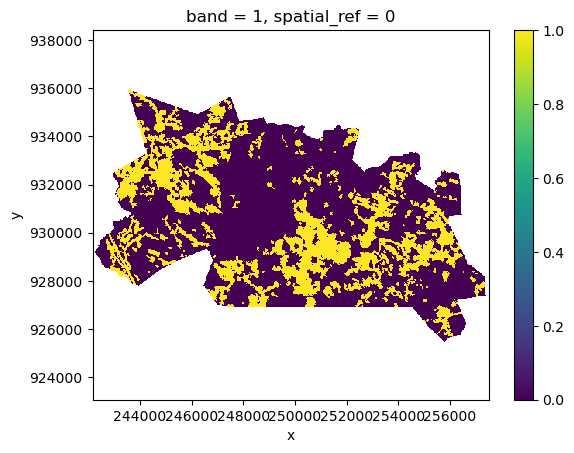

In [19]:
# access the predicted map as part of the model class
landchange_model02.predicted_map.plot()

In [20]:
# call validate to get the CROSSTAB table
landchange_model02.validate()

{'True Positives': 27145,
 'True Negatives': 68400,
 'False Positives': 4158,
 'False Negatives': 3487,
 'Precision': 0.8671692808995943,
 'Recall': 0.8861647949856359,
 'F1 Score': 0.876564139824009}